# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning - Project
---

## "Mind the Gap" - A Deep Learning Analysis of Pothole Detection
---

|                  Name                     |      Campus Email              | Personal Email        |
|-------------------------------------------|--------------------------------|-----------------------|
|[Itai Benyamin](https://github.com/Itai-b) | itai.b@campus.technion.ac.il   |itai.benyamin@gmail.com|
|[Idan Baruch](https://github.com/idanbaru) | idan-b@campus.technion.ac.il   |idanb12200@gmail.com   |

## Introduction

## Background

## Imports

In [92]:
import os
import ast
import gc
import shutil
import xmltodict
import random
import numpy as np
import pandas as pd
import time
import copy
import re
from enum import Enum
import cv2
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision
from torchmetrics.detection import MeanAveragePrecision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub as kh
from tqdm import tqdm

# Set random seed for reproducibility
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pin_memory = True if device == "cuda:0" else False

print("pytorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch built with CUDA:", torch.backends.cuda.is_built())
print("Available devices:", torch.cuda.device_count())
print("Current device:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No device")

pytorch version: 2.5.1
torchvision version: 0.20.1
Is CUDA available: True
CUDA version: 11.8
PyTorch built with CUDA: True
Available devices: 1
Current device: NVIDIA GeForce RTX 3090


## Data Loading

In [ ]:
kaggle_datapath = 'andrewmvd/pothole-detection'
data_path = 'data/andrewmvd_pothole_detection'
if not os.path.exists(data_path):
    #Load the data from kaggle
    data = kh.dataset_download(kaggle_datapath)
    # Move the data to the correct location
    shutil.move(data, data_path)
else:
    print('Data already exists')

100%|██████████| 334M/334M [00:13<00:00, 25.6MB/s] 

Extracting files...


In [94]:
class PotholeSeverity(Enum):
    """
    Enum class for the severity of potholes.
    The severity levels ranges from 0 (no pothole) to 4 (major pothole):
        0 - No pothole (background, shouldn't be a detection target)
        temporary 1 - general pothole, no specific severity)
        1 - Minor pothole (road damage that is non-dangerous for padestrians)
        2 - Medium pothole (road damage that is dangerous for padestrians, but not for vehicles)
        3 - Major pothole (road damage that is dangerous for both vehicles and padestrians)
    """
    NO_POTHOLE = 0
    POTHOLE = 1 # TODO - this label is for temporary until we classify each saverity in the data.
    #MINOR_POTHOLE = 1
    #MEDIUM_POTHOLE = 2
    #MAJOR_POTHOLE = 3

def get_label_name(label):
    return PotholeSeverity(label).name

class PotholeDetectionDataset:
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        
        # Preprocess data
        self.img_files, self.ann_files = self._preprocess_dataset()

    
    @staticmethod
    def _extract_index(filename):
        # Use a regex to extract the numeric index from the file name
        match = re.search(r'\d+', filename)
        return int(match.group()) if match else float('inf')

    def _preprocess_dataset(self):
        # Get images from folder
        img_files = sorted(os.listdir(self.img_dir), key=self._extract_index)
        ann_files = sorted(os.listdir(self.ann_dir), key=self._extract_index)

        valid_img_files = []
        valid_ann_files = []

        # Parse images and annotated boxes to return only the valid images and boxes
        for img_file, ann_file in zip(img_files, ann_files):
            img_path = os.path.join(self.img_dir, img_file)
            ann_path = os.path.join(self.ann_dir, ann_file)
            
            # Load and validate
            img = cv2.imread(img_path)
            img_height, img_width = img.shape[:2]
            boxes, _ = self.parse_voc_annotation(ann_path)
            
            if self._check_boxes_validity(boxes, img_width, img_height):
                valid_img_files.append(img_file)
                valid_ann_files.append(ann_file)
                assert len(valid_img_files) == len(valid_ann_files)
        
        print(f'Number of valid images: {len(valid_img_files)}')
        return valid_img_files, valid_ann_files
    
    @staticmethod
    def _check_boxes_validity(boxes, img_width, img_height):
        for xmin, ymin, xmax, ymax in boxes:
            width = xmax - xmin
            height = ymax - ymin
            
            if width <= 0 or height <= 0:
                return False
            if xmin < 0 or ymin < 0 or xmax > img_width or ymax > img_height:
                return False
        return True

    def parse_voc_annotation(self, ann_path):
        with open(ann_path) as f:
            ann_data = xmltodict.parse(f.read())
        
        boxes = []
        labels = []
        objects = ann_data["annotation"].get("object", [])
        if not isinstance(objects, list):
            objects = [objects]
        
        for obj in objects:
            bbox = obj["bndbox"]
            xmin = int(float(bbox["xmin"]))
            ymin = int(float(bbox["ymin"]))
            xmax = int(float(bbox["xmax"]))
            ymax = int(float(bbox["ymax"]))
            boxes.append((xmin, ymin, xmax, ymax))
            labels.append(PotholeSeverity.POTHOLE.value)
        
        return boxes, labels
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        ann_path = os.path.join(self.ann_dir, self.ann_files[idx])
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_size = img.shape[:2]  # (height, width)
        
        # Load annotations
        boxes, labels = self.parse_voc_annotation(ann_path)
        
        # Apply transform
        if self.transform is not None:
            img_pil = torchvision.transforms.ToPILImage()(img)
            img = self.transform(img_pil)
            new_size = (img.shape[2], img.shape[1])  # (width, height)
            
            # Adjust bounding boxes
            orig_h, orig_w = original_size
            new_w, new_h = new_size
            x_scale = new_w / orig_w
            y_scale = new_h / orig_h
            boxes = [
                (int(xmin * x_scale), int(ymin * y_scale), int(xmax * x_scale), int(ymax * y_scale))
                for xmin, ymin, xmax, ymax in boxes
            ]
            
            target = {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
                "image_id": torch.tensor([idx], dtype=torch.int64),
                "area": torch.tensor([(xmax - xmin) * (ymax - ymin) for xmin, ymin, xmax, ymax in boxes], dtype=torch.float32),
                "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)
            }

        
        return img, target
    
# custom collate_fn for torch DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# Paths to images and annotations
img_dir = os.path.join(data_path,"images")
ann_dir = os.path.join(data_path,"annotations")

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with values [0, 1]
])

# Initialize the dataset
dataset = PotholeDetectionDataset(img_dir, ann_dir, transform=transform)

# Split the dataset to train, validation, and test sets (70-10-20)
#train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=seed)
#train_set, val_set = train_test_split(train_set, test_size=0.125, random_state=seed)

# Maintain the original indices while splitting
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.125, random_state=seed)

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

print(f"Train set size: {len(train_set)} - {len(train_set)/len(dataset)*100:.2f}%")
print(f"Validation set size: {len(val_set)} - {len(val_set)/len(dataset)*100:.2f}%")
print(f"Test set size: {len(test_set)} - {len(test_set)/len(dataset)*100:.2f}%")

Number of valid images: 663
Train set size: 463 - 69.83%
Validation set size: 67 - 10.11%
Test set size: 133 - 20.06%


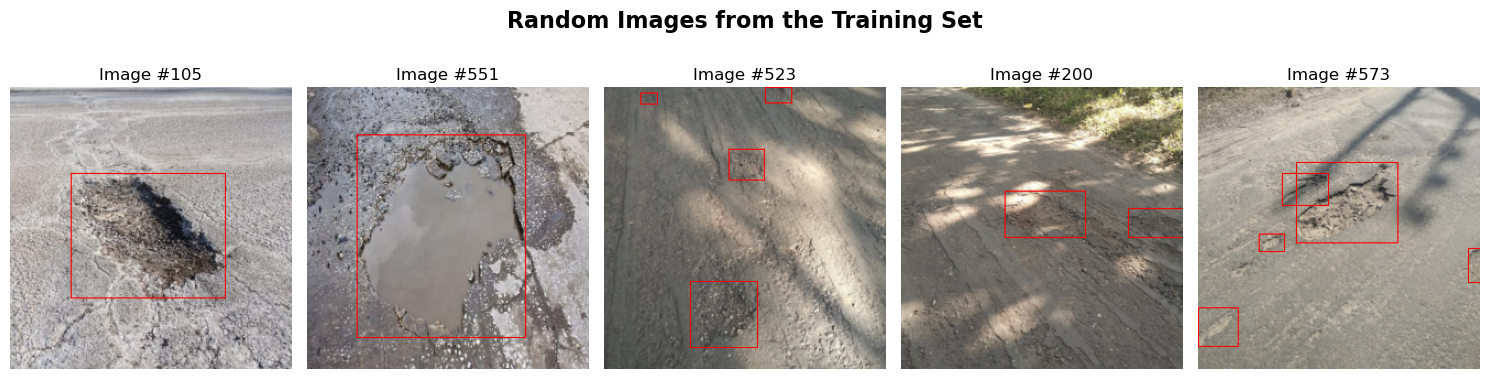

In [121]:
# Display 5 random images from the training set
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, collate_fn=collate_fn)
images, targets = next(iter(train_loader))

fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, (img, target) in enumerate(zip(images, targets)):
    img_np = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format
    img_np = (img_np * 255).astype(np.uint8).copy()  # Scale and convert to uint8
    
    for box, label in zip(target["boxes"], target["labels"]):
        cv2.rectangle(img_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 1)
        label = get_label_name(target["labels"][0].item())
        #cv2.putText(img_np, label, (int(box[0]), int(box[1] - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    
    axs[i].imshow(img_np)
    axs[i].axis("off")
    axs[i].set_title(f"Image #{target['image_id'].item()}")

# Add a main title
plt.suptitle("Random Images from the Training Set", fontsize=16, fontweight="bold", y=0.9)

plt.tight_layout()
plt.show()


## Loss Functions

In [ ]:
def calc_loss(predictions, targets, class_loss_func = torch.nn.functional.cross_entropy, localization_func = torch.nn.box_iou, localization_loss_func = torch.ops.box_iou,threshold = 0.5):
    """
    A general loss function for object detection.
    The function calculates the loss for both localization and classification.
    class_loss_func - a function that calculates the loss for the class labels. (i.e. nn.functional.cross_entropy)
    localization_fucn - a function that returns a NxM matrix containing the pairwise IoU/GIoU/DIoU values for every element in boxes1 and boxes2
    """
    localization_loss = 0.0       # penalty for inaccurate box locations and areas
    classification_loss = 0.0     # penalty for incorrect class predictions (incorrect labels)
    
    for pred, target in zip(predictions, targets):
        # prediction and ground truth for a single image
        pred_boxes = pred["boxes"]
        pred_labels = pred["labels"]
        target_boxes = target["boxes"]
        target_labels = target["labels"]
        
        # Step 1: compute localization matrix (iou, giou, diou) between all prediction and target boxes
        # localization function returns a  NxM matrix containing the pairwise IoU values for every element in boxes1 and boxes2
        # Shape = [num_pred, num_targets]
        localization_matrix += localization_func(pred_boxes, target_boxes)
        
        # Step 2: match predictions to ground truth boxes based on the localization matrix
        matched_preds = []
        matched_targets = []
        # for each ground truth box, find the prediction with the highest localization score (i.e.: IoU/GIoU/DIoU)
        for target_idx in range(localization_matrix.size(1)):
            max_score, pred_idx = torch.max(localization_matrix[:, target_idx], dim=0)
            # take only IoU score above threshold
            if max_score > threshold:
                matched_preds.append(pred_idx)
                matched_targets.append(target_idx)
        
        matched_preds = torch.tensor(matched_preds, dtype=torch.long)
        matched_targets = torch.tensor(matched_targets, dtype=torch.long)

        # Step 3: compute localization loss
        # check if there are matched predictions
        if matched_preds.numel() > 0:
            matched_pred_boxes = pred_boxes[matched_preds]
            matched_target_boxes = target_boxes[matched_targets]
            # loss function should match the localization func (i.e., torch.nn.func and torch.ops.func respectively)
            localization_loss += localization_loss_func(matched_pred_boxes, matched_target_boxes)

        # TODO: (optional) add penalty for numel() == 0 (no matches)
        # Step 4: compute classification loss
        if matched_preds.numel() > 0:
            matched_pred_labels = pred_labels[matched_preds]  # Shape: [num_matched, num_classes]
            matched_target_labels = target_labels[matched_targets]  # Shape: [num_matched]
            classification_loss += class_loss_func(matched_pred_labels, matched_target_labels)

        # Step 5: Handle unmatched predictions (false positives) and targets (false negatives)
        unmatched_preds = set(range(pred_boxes.size(0))) - set(matched_preds.tolist())
        unmatched_targets = set(range(target_boxes.size(0))) - set(matched_targets.tolist())
        # TODO +: Add penalties for unmatched predictions/targets if needed

    return localization_loss, classification_loss

## Custom CNN

## faster_rcnn

In [103]:
def compute_validation_loss(predictions, targets):
    """
    Compute validation loss based on IoU matching between predictions and targets.
    """
    total_loss = 0.0
    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes']
        target_boxes = target['boxes']
        
        # Ensure there are predictions and targets to compare
        if pred_boxes.numel() == 0 or target_boxes.numel() == 0:
            continue
        
        # Calculate IoU for each prediction-target pair
        iou_matrix = torchvision.ops.box_iou(pred_boxes, target_boxes)
        
        # Match predictions to targets based on IoU
        matched_vals, matched_idxs = iou_matrix.max(dim=1)
        
        # Consider only matches with IoU > 0.5
        valid_matches = matched_vals > 0.5
        matched_preds = pred_boxes[valid_matches]
        matched_targets = target_boxes[matched_idxs[valid_matches]]
        
        # Compute L1 loss for matched boxes
        if matched_preds.numel() > 0 and matched_targets.numel() > 0:
            l1_loss = torch.nn.functional.l1_loss(matched_preds, matched_targets, reduction='mean')
            total_loss += l1_loss.item()
    
    return total_loss


# Training function
# TODO - explain the trade-off between batch size and number of epochs
# TODO -add validation check
def train(model, traim_loader, val_loader, optimizer, lr_scheduler, num_epochs):
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        epoch_train_loss = 0.0
        
        for images, targets in train_loader:
            # Prepare inputs for the model
            images = [img.to(device) for img in images]
            
            # Convert relevant target values to device
            targets_to_device = []
            for target in targets:
                targets_to_device.append({
                    'boxes': target['boxes'].to(device),
                    'labels': target['labels'].to(device)
                })

            # Compute training loss
            loss_dict = model(images, targets_to_device)
            losses = sum(loss for loss in loss_dict.values())
            epoch_train_loss += losses.item()

            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Step the learning rate scheduler
        lr_scheduler.step()

        # Calculate and append average training loss (per epoch)
        average_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(average_train_loss)
        
        
        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                # Prepare inputs for the model
                images = [img.to(device) for img in images]
                
                # Convert relevant target values to device
                targets_to_device = []
                for target in targets:
                    targets_to_device.append({
                        'boxes': target['boxes'].to(device),
                        'labels': target['labels'].to(device)
                    })
                
                # Compute validation loss
                predictions = model(images)
                
                # Compute validation loss using a custom loss function
                val_loss = compute_validation_loss(predictions, targets_to_device)
                epoch_val_loss += val_loss

            
        # Calculate and append average validation loss (per epoch)
        average_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(average_val_loss)
        
        
        # Print epoch summary
        tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {average_train_loss:.4f} - Val Loss: {average_val_loss:.4f}")


    # Save the trained model
    model_name = f"faster_rcnn_pothole_{batch_size}.pth"
    torch.save(model.state_dict(), model_name)
    print(f"Model training complete. Saved as '{model_name}'")
    
    # Return the losses
    return train_losses, val_losses


# Train the model over different batch sizes
results = {}
num_epochs = 25
for batch_size in [2, 4, 8, 16]:
    ## clear memory
    gc.collect()
    torch.cuda.empty_cache()
    
    # TODO - explain what is the loss function that is used.
    # Define the model (load pretrained weights of Resnet50-FPN on COCO_V1 dataset)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

    # Replace the classifier with a single-class output
    num_classes = len(PotholeSeverity)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # Move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define optimizer and learning rate scheduler
    # TODO - explain chosen hyperparameters
    optimizer = torch.optim.SGD(model.parameters(),lr=0.005,momentum=0.9,weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    # Create data loaders
    train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
    val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False,collate_fn=collate_fn)
    
    # TODO: check if need to run 10 to 100 epochs and not 100 right away and collect best epoch num
    #for num_epochs in [10, 20, 50, 100]:
    
    train_losses, val_losses = train(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs=num_epochs)
    results[batch_size] = (train_losses, val_losses)

Epochs:   4%|▍         | 1/25 [00:27<11:01, 27.54s/it]

Epoch 1/25 - Train Loss: 0.3749 - Val Loss: 12.1233


Epochs:   8%|▊         | 2/25 [00:55<10:42, 27.93s/it]

Epoch 2/25 - Train Loss: 0.2632 - Val Loss: 11.3400


Epochs:  12%|█▏        | 3/25 [01:23<10:10, 27.73s/it]

Epoch 3/25 - Train Loss: 0.2359 - Val Loss: 10.2490


Epochs:  16%|█▌        | 4/25 [01:50<09:39, 27.61s/it]

Epoch 4/25 - Train Loss: 0.1682 - Val Loss: 9.3340


Epochs:  20%|██        | 5/25 [02:18<09:12, 27.65s/it]

Epoch 5/25 - Train Loss: 0.1460 - Val Loss: 7.7501


Epochs:  24%|██▍       | 6/25 [02:45<08:44, 27.60s/it]

Epoch 6/25 - Train Loss: 0.1345 - Val Loss: 8.0236


Epochs:  28%|██▊       | 7/25 [03:13<08:17, 27.62s/it]

Epoch 7/25 - Train Loss: 0.1259 - Val Loss: 7.6564


Epochs:  32%|███▏      | 8/25 [03:41<07:50, 27.66s/it]

Epoch 8/25 - Train Loss: 0.1233 - Val Loss: 7.5838


Epochs:  36%|███▌      | 9/25 [04:09<07:25, 27.84s/it]

Epoch 9/25 - Train Loss: 0.1224 - Val Loss: 8.0055


Epochs:  40%|████      | 10/25 [04:37<06:56, 27.77s/it]

Epoch 10/25 - Train Loss: 0.1212 - Val Loss: 8.0040


Epochs:  44%|████▍     | 11/25 [05:04<06:27, 27.71s/it]

Epoch 11/25 - Train Loss: 0.1206 - Val Loss: 7.9989


Epochs:  48%|████▊     | 12/25 [05:32<05:59, 27.68s/it]

Epoch 12/25 - Train Loss: 0.1209 - Val Loss: 7.8756


Epochs:  52%|█████▏    | 13/25 [06:00<05:33, 27.82s/it]

Epoch 13/25 - Train Loss: 0.1210 - Val Loss: 7.8754


Epochs:  56%|█████▌    | 14/25 [06:28<05:05, 27.81s/it]

Epoch 14/25 - Train Loss: 0.1205 - Val Loss: 7.8752


Epochs:  60%|██████    | 15/25 [06:56<04:39, 27.95s/it]

Epoch 15/25 - Train Loss: 0.1210 - Val Loss: 7.8752


Epochs:  64%|██████▍   | 16/25 [07:24<04:10, 27.83s/it]

Epoch 16/25 - Train Loss: 0.1214 - Val Loss: 7.8756


Epochs:  68%|██████▊   | 17/25 [07:51<03:41, 27.70s/it]

Epoch 17/25 - Train Loss: 0.1209 - Val Loss: 7.8751


Epochs:  72%|███████▏  | 18/25 [08:18<03:13, 27.63s/it]

Epoch 18/25 - Train Loss: 0.1208 - Val Loss: 7.8757


Epochs:  76%|███████▌  | 19/25 [08:46<02:46, 27.72s/it]

Epoch 19/25 - Train Loss: 0.1214 - Val Loss: 7.8755


Epochs:  80%|████████  | 20/25 [09:14<02:18, 27.73s/it]

Epoch 20/25 - Train Loss: 0.1217 - Val Loss: 7.8752


Epochs:  84%|████████▍ | 21/25 [09:42<01:50, 27.74s/it]

Epoch 21/25 - Train Loss: 0.1198 - Val Loss: 7.8753


Epochs:  88%|████████▊ | 22/25 [10:09<01:23, 27.68s/it]

Epoch 22/25 - Train Loss: 0.1209 - Val Loss: 7.8752


Epochs:  92%|█████████▏| 23/25 [10:37<00:55, 27.64s/it]

Epoch 23/25 - Train Loss: 0.1210 - Val Loss: 7.8752


Epochs:  96%|█████████▌| 24/25 [11:05<00:27, 27.76s/it]

Epoch 24/25 - Train Loss: 0.1206 - Val Loss: 7.8752


Epochs: 100%|██████████| 25/25 [11:33<00:00, 27.74s/it]


Epoch 25/25 - Train Loss: 0.1204 - Val Loss: 7.8752
Model training complete. Saved as 'faster_rcnn_pothole_2.pth'


Epochs:   4%|▍         | 1/25 [00:24<09:57, 24.91s/it]

Epoch 1/25 - Train Loss: 0.3816 - Val Loss: 25.8961


Epochs:   8%|▊         | 2/25 [00:49<09:33, 24.92s/it]

Epoch 2/25 - Train Loss: 0.2722 - Val Loss: 20.2444


Epochs:  12%|█▏        | 3/25 [01:14<09:07, 24.89s/it]

Epoch 3/25 - Train Loss: 0.2218 - Val Loss: 20.5118


Epochs:  16%|█▌        | 4/25 [01:39<08:42, 24.87s/it]

Epoch 4/25 - Train Loss: 0.1732 - Val Loss: 17.3638


Epochs:  20%|██        | 5/25 [02:04<08:17, 24.89s/it]

Epoch 5/25 - Train Loss: 0.1551 - Val Loss: 15.9661


Epochs:  24%|██▍       | 6/25 [02:29<07:55, 25.00s/it]

Epoch 6/25 - Train Loss: 0.1461 - Val Loss: 16.8990


Epochs:  28%|██▊       | 7/25 [02:54<07:29, 24.97s/it]

Epoch 7/25 - Train Loss: 0.1378 - Val Loss: 17.1316


Epochs:  32%|███▏      | 8/25 [03:19<07:03, 24.92s/it]

Epoch 8/25 - Train Loss: 0.1368 - Val Loss: 16.9991


Epochs:  36%|███▌      | 9/25 [03:44<06:37, 24.86s/it]

Epoch 9/25 - Train Loss: 0.1357 - Val Loss: 15.9004


Epochs:  40%|████      | 10/25 [04:09<06:13, 24.92s/it]

Epoch 10/25 - Train Loss: 0.1346 - Val Loss: 15.7477


Epochs:  44%|████▍     | 11/25 [04:34<05:49, 24.99s/it]

Epoch 11/25 - Train Loss: 0.1342 - Val Loss: 15.7684


Epochs:  48%|████▊     | 12/25 [04:59<05:24, 25.00s/it]

Epoch 12/25 - Train Loss: 0.1343 - Val Loss: 15.7712


Epochs:  52%|█████▏    | 13/25 [05:24<05:00, 25.08s/it]

Epoch 13/25 - Train Loss: 0.1346 - Val Loss: 15.7709


Epochs:  56%|█████▌    | 14/25 [05:49<04:36, 25.11s/it]

Epoch 14/25 - Train Loss: 0.1341 - Val Loss: 15.7709


Epochs:  60%|██████    | 15/25 [06:15<04:11, 25.14s/it]

Epoch 15/25 - Train Loss: 0.1344 - Val Loss: 15.7716


Epochs:  64%|██████▍   | 16/25 [06:39<03:45, 25.02s/it]

Epoch 16/25 - Train Loss: 0.1347 - Val Loss: 15.7702


Epochs:  68%|██████▊   | 17/25 [07:04<03:20, 25.00s/it]

Epoch 17/25 - Train Loss: 0.1342 - Val Loss: 15.7716


Epochs:  72%|███████▏  | 18/25 [07:30<02:57, 25.30s/it]

Epoch 18/25 - Train Loss: 0.1342 - Val Loss: 15.7711


Epochs:  76%|███████▌  | 19/25 [07:56<02:32, 25.39s/it]

Epoch 19/25 - Train Loss: 0.1342 - Val Loss: 15.7967


Epochs:  80%|████████  | 20/25 [08:19<02:04, 24.81s/it]

Epoch 20/25 - Train Loss: 0.1342 - Val Loss: 15.7717


Epochs:  84%|████████▍ | 21/25 [08:43<01:37, 24.38s/it]

Epoch 21/25 - Train Loss: 0.1348 - Val Loss: 15.7713


Epochs:  88%|████████▊ | 22/25 [09:06<01:12, 24.02s/it]

Epoch 22/25 - Train Loss: 0.1344 - Val Loss: 15.7715


Epochs:  92%|█████████▏| 23/25 [09:30<00:48, 24.14s/it]

Epoch 23/25 - Train Loss: 0.1343 - Val Loss: 15.7712


Epochs:  96%|█████████▌| 24/25 [09:55<00:24, 24.31s/it]

Epoch 24/25 - Train Loss: 0.1345 - Val Loss: 15.7713


Epochs: 100%|██████████| 25/25 [10:20<00:00, 24.81s/it]


Epoch 25/25 - Train Loss: 0.1347 - Val Loss: 15.7713
Model training complete. Saved as 'faster_rcnn_pothole_4.pth'


Epochs:   4%|▍         | 1/25 [00:24<09:41, 24.23s/it]

Epoch 1/25 - Train Loss: 0.4141 - Val Loss: 45.1306


Epochs:   8%|▊         | 2/25 [00:48<09:12, 24.03s/it]

Epoch 2/25 - Train Loss: 0.2531 - Val Loss: 38.8729


Epochs:  12%|█▏        | 3/25 [01:11<08:43, 23.81s/it]

Epoch 3/25 - Train Loss: 0.2203 - Val Loss: 35.7352


Epochs:  16%|█▌        | 4/25 [01:35<08:17, 23.71s/it]

Epoch 4/25 - Train Loss: 0.1798 - Val Loss: 32.3629


Epochs:  20%|██        | 5/25 [01:59<07:56, 23.81s/it]

Epoch 5/25 - Train Loss: 0.1620 - Val Loss: 32.9969


Epochs:  24%|██▍       | 6/25 [02:23<07:33, 23.89s/it]

Epoch 6/25 - Train Loss: 0.1557 - Val Loss: 31.3965


Epochs:  28%|██▊       | 7/25 [02:46<07:07, 23.77s/it]

Epoch 7/25 - Train Loss: 0.1491 - Val Loss: 31.3232


Epochs:  32%|███▏      | 8/25 [03:10<06:42, 23.70s/it]

Epoch 8/25 - Train Loss: 0.1479 - Val Loss: 32.4873


Epochs:  36%|███▌      | 9/25 [03:33<06:17, 23.61s/it]

Epoch 9/25 - Train Loss: 0.1473 - Val Loss: 34.9535


Epochs:  40%|████      | 10/25 [03:57<05:54, 23.60s/it]

Epoch 10/25 - Train Loss: 0.1466 - Val Loss: 34.9499


Epochs:  44%|████▍     | 11/25 [04:20<05:29, 23.56s/it]

Epoch 11/25 - Train Loss: 0.1462 - Val Loss: 34.9439


Epochs:  48%|████▊     | 12/25 [04:44<05:05, 23.47s/it]

Epoch 12/25 - Train Loss: 0.1466 - Val Loss: 34.9354


Epochs:  52%|█████▏    | 13/25 [05:07<04:41, 23.44s/it]

Epoch 13/25 - Train Loss: 0.1458 - Val Loss: 34.9448


Epochs:  56%|█████▌    | 14/25 [05:30<04:17, 23.45s/it]

Epoch 14/25 - Train Loss: 0.1468 - Val Loss: 34.9355


Epochs:  60%|██████    | 15/25 [05:54<03:55, 23.51s/it]

Epoch 15/25 - Train Loss: 0.1466 - Val Loss: 34.9364


Epochs:  64%|██████▍   | 16/25 [06:17<03:31, 23.47s/it]

Epoch 16/25 - Train Loss: 0.1469 - Val Loss: 34.9346


Epochs:  68%|██████▊   | 17/25 [06:41<03:07, 23.45s/it]

Epoch 17/25 - Train Loss: 0.1460 - Val Loss: 34.9342


Epochs:  72%|███████▏  | 18/25 [07:04<02:44, 23.44s/it]

Epoch 18/25 - Train Loss: 0.1463 - Val Loss: 34.9351


Epochs:  76%|███████▌  | 19/25 [07:28<02:20, 23.44s/it]

Epoch 19/25 - Train Loss: 0.1463 - Val Loss: 34.9359


Epochs:  80%|████████  | 20/25 [07:51<01:57, 23.50s/it]

Epoch 20/25 - Train Loss: 0.1466 - Val Loss: 34.9359


Epochs:  84%|████████▍ | 21/25 [08:15<01:33, 23.43s/it]

Epoch 21/25 - Train Loss: 0.1464 - Val Loss: 34.9362


Epochs:  88%|████████▊ | 22/25 [08:38<01:10, 23.39s/it]

Epoch 22/25 - Train Loss: 0.1466 - Val Loss: 34.9363


Epochs:  92%|█████████▏| 23/25 [09:01<00:46, 23.35s/it]

Epoch 23/25 - Train Loss: 0.1472 - Val Loss: 34.9362


Epochs:  96%|█████████▌| 24/25 [09:24<00:23, 23.32s/it]

Epoch 24/25 - Train Loss: 0.1465 - Val Loss: 34.9366


Epochs: 100%|██████████| 25/25 [09:48<00:00, 23.53s/it]


Epoch 25/25 - Train Loss: 0.1461 - Val Loss: 34.9366
Model training complete. Saved as 'faster_rcnn_pothole_8.pth'


Epochs:   4%|▍         | 1/25 [00:21<08:34, 21.43s/it]

Epoch 1/25 - Train Loss: 0.4758 - Val Loss: 106.0479


Epochs:   8%|▊         | 2/25 [00:42<08:09, 21.30s/it]

Epoch 2/25 - Train Loss: 0.3002 - Val Loss: 74.3708


Epochs:  12%|█▏        | 3/25 [01:03<07:48, 21.29s/it]

Epoch 3/25 - Train Loss: 0.2546 - Val Loss: 70.3400


Epochs:  16%|█▌        | 4/25 [01:25<07:26, 21.27s/it]

Epoch 4/25 - Train Loss: 0.2195 - Val Loss: 65.4061


Epochs:  20%|██        | 5/25 [01:46<07:05, 21.26s/it]

Epoch 5/25 - Train Loss: 0.2083 - Val Loss: 61.4219


Epochs:  24%|██▍       | 6/25 [02:07<06:44, 21.27s/it]

Epoch 6/25 - Train Loss: 0.2030 - Val Loss: 60.6566


Epochs:  28%|██▊       | 7/25 [02:28<06:22, 21.27s/it]

Epoch 7/25 - Train Loss: 0.2003 - Val Loss: 63.3465


Epochs:  32%|███▏      | 8/25 [02:50<06:01, 21.26s/it]

Epoch 8/25 - Train Loss: 0.2002 - Val Loss: 61.2741


Epochs:  36%|███▌      | 9/25 [03:11<05:40, 21.26s/it]

Epoch 9/25 - Train Loss: 0.1981 - Val Loss: 61.8885


Epochs:  40%|████      | 10/25 [03:32<05:18, 21.26s/it]

Epoch 10/25 - Train Loss: 0.1980 - Val Loss: 61.7532


Epochs:  44%|████▍     | 11/25 [03:54<04:57, 21.28s/it]

Epoch 11/25 - Train Loss: 0.1987 - Val Loss: 61.7424


Epochs:  48%|████▊     | 12/25 [04:15<04:36, 21.27s/it]

Epoch 12/25 - Train Loss: 0.1977 - Val Loss: 61.7344


Epochs:  52%|█████▏    | 13/25 [04:36<04:15, 21.27s/it]

Epoch 13/25 - Train Loss: 0.1977 - Val Loss: 61.7326


Epochs:  56%|█████▌    | 14/25 [04:57<03:53, 21.27s/it]

Epoch 14/25 - Train Loss: 0.1974 - Val Loss: 61.7317


Epochs:  60%|██████    | 15/25 [05:19<03:32, 21.28s/it]

Epoch 15/25 - Train Loss: 0.1982 - Val Loss: 61.7306


Epochs:  64%|██████▍   | 16/25 [05:40<03:11, 21.27s/it]

Epoch 16/25 - Train Loss: 0.1978 - Val Loss: 61.7315


Epochs:  68%|██████▊   | 17/25 [06:01<02:50, 21.27s/it]

Epoch 17/25 - Train Loss: 0.1977 - Val Loss: 61.7305


Epochs:  72%|███████▏  | 18/25 [06:22<02:28, 21.27s/it]

Epoch 18/25 - Train Loss: 0.1975 - Val Loss: 61.7303


Epochs:  76%|███████▌  | 19/25 [06:44<02:07, 21.26s/it]

Epoch 19/25 - Train Loss: 0.1982 - Val Loss: 61.7314


Epochs:  80%|████████  | 20/25 [07:05<01:46, 21.27s/it]

Epoch 20/25 - Train Loss: 0.1976 - Val Loss: 61.7311


Epochs:  84%|████████▍ | 21/25 [07:26<01:25, 21.27s/it]

Epoch 21/25 - Train Loss: 0.1984 - Val Loss: 61.7311


Epochs:  88%|████████▊ | 22/25 [07:47<01:03, 21.26s/it]

Epoch 22/25 - Train Loss: 0.1975 - Val Loss: 61.7311


Epochs:  92%|█████████▏| 23/25 [08:09<00:42, 21.25s/it]

Epoch 23/25 - Train Loss: 0.1980 - Val Loss: 61.7311


Epochs:  96%|█████████▌| 24/25 [08:30<00:21, 21.25s/it]

Epoch 24/25 - Train Loss: 0.1980 - Val Loss: 61.7311


Epochs: 100%|██████████| 25/25 [08:51<00:00, 21.27s/it]


Epoch 25/25 - Train Loss: 0.1978 - Val Loss: 61.7311
Model training complete. Saved as 'faster_rcnn_pothole_16.pth'


In [ ]:
# Save the data to a csv file (using pandas)
results_df = pd.DataFrame(results)
results_df.to_csv("./data/faster_rcnn_pothole_batches.csv", index=False)

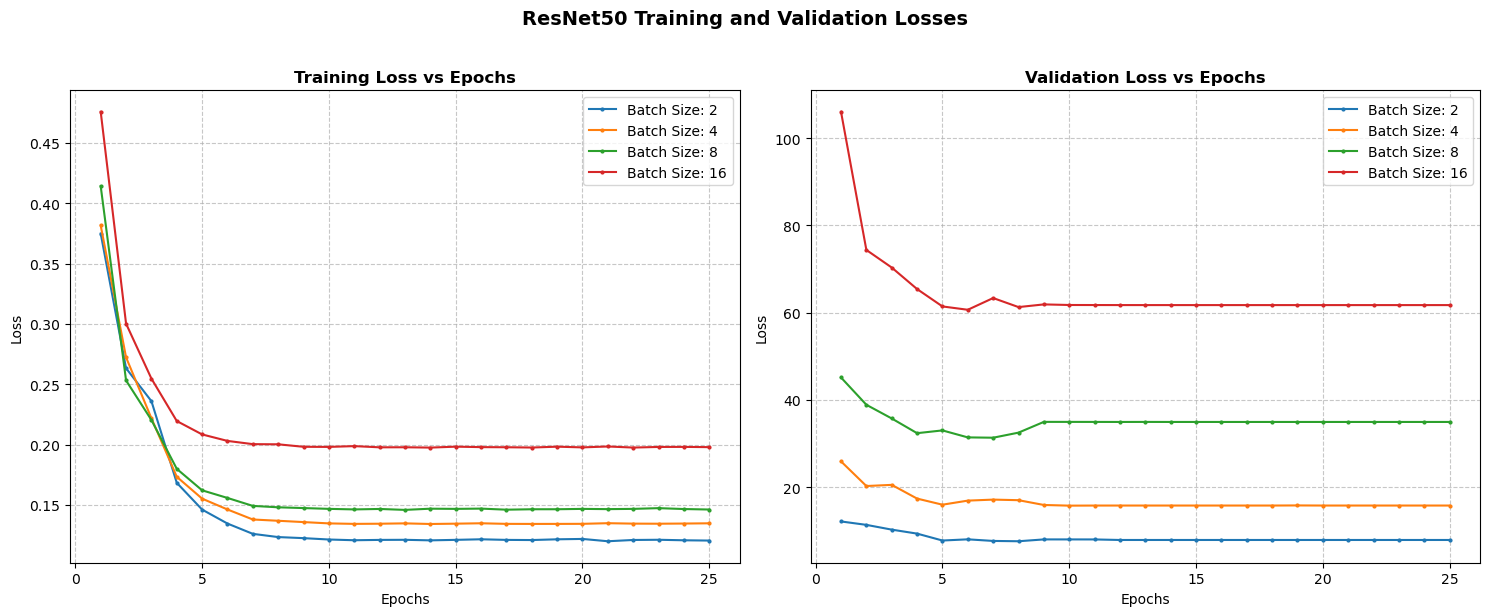

In [118]:
# Load the data from the csv file
results_df = pd.read_csv("./data/faster_rcnn_pothole_batches.csv")

# Process the data
batch_sizes = [2, 4, 8, 16]
results = {}

for batch_size in batch_sizes:
    # Convert string representations of lists to actual lists
    train_losses = ast.literal_eval(results_df[str(batch_size)].iloc[0])
    val_losses = ast.literal_eval(results_df[str(batch_size)].iloc[1])
    results[batch_size] = (train_losses, val_losses)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Add suptitle for the model
fig.suptitle('ResNet50 Training and Validation Losses', fontsize=14, fontweight='bold', y=1.02)

# Plot training losses
for batch_size, (train_losses, val_losses) in results.items():
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, label=f'Batch Size: {batch_size}', marker='o', markersize=2)

ax1.set_title('Training Loss vs Epochs', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=10)
ax1.set_ylabel('Loss', fontsize=10)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot validation losses
for batch_size, (train_losses, val_losses) in results.items():
    epochs = range(1, len(val_losses) + 1)
    ax2.plot(epochs, val_losses, label=f'Batch Size: {batch_size}', marker='o', markersize=2)

ax2.set_title('Validation Loss vs Epochs', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=10)
ax2.set_ylabel('Loss', fontsize=10)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [73]:
# TODO - explain what is the loss function that is used.
# Define the dataset and DataLoader
train_loader = DataLoader(
    train_set,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_set,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

# Define the model (load pretrained weights of Resnet50-FPN on COCO_V1 dataset)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Replace the classifier with a single-class output
num_classes = len(PotholeSeverity)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and learning rate scheduler
# TODO - explain chosen hyperparameters
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
# TODO - explain the trade-off between batch size and number of epochs
# TODO -add validation check
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        # Prepare inputs for the model
        images = [img.to(device) for img in images]
        #targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
        # Convert relevant target values to device
        targets_to_device = []
        for target in targets:
            targets_to_device.append({
                'boxes': target['boxes'].to(device),
                'labels': target['labels'].to(device)
            })
    
        
        # Compute loss
        loss_dict = model(images, targets_to_device)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        
        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    # Step the learning rate scheduler
    lr_scheduler.step()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "faster_rcnn_pothole.pth")
print("Model training complete. Saved as 'faster_rcnn_pothole.pth'.")

Epoch 1/20, Loss: 24.6768
Epoch 2/20, Loss: 15.9249
Epoch 3/20, Loss: 12.6866
Epoch 4/20, Loss: 9.8223
Epoch 5/20, Loss: 9.2794
Epoch 6/20, Loss: 8.8755
Epoch 7/20, Loss: 8.6593
Epoch 8/20, Loss: 8.6372
Epoch 9/20, Loss: 8.5593
Epoch 10/20, Loss: 8.5513
Epoch 11/20, Loss: 8.5102
Epoch 12/20, Loss: 8.5278
Epoch 13/20, Loss: 8.5089
Epoch 14/20, Loss: 8.4884
Epoch 15/20, Loss: 8.5059
Epoch 16/20, Loss: 8.5141
Epoch 17/20, Loss: 8.4784
Epoch 18/20, Loss: 8.4783
Epoch 19/20, Loss: 8.5076
Epoch 20/20, Loss: 8.5361
Model training complete. Saved as 'faster_rcnn_pothole.pth'.


In [63]:
# Function to calculate test score (e.g., mean Average Precision)
def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()  # Ensure the model is in evaluation mode
    all_predictions = {}
    #all_ground_truths = {}
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(data_loader):
            # Prepare images for inference
            inputs = [img.to(device) for img in images]
            
            # Run model inference
            outputs = model(inputs)
            #print(f"Outputs for batch {batch_idx}: {outputs}")
            # Collect predictions and ground truth
            for i, (output, target) in enumerate(zip(outputs, targets)):
                image_id = target["image_id"].item()
                gt_boxes = target["boxes"].cpu().numpy().tolist()
                
                predictions = [
                    (box.tolist(), label.item(), score.item())
                    for box, label, score in zip(output['boxes'], output['labels'], output['scores'])
                    if score >= threshold
                ]
                all_predictions[image_id] = predictions
    return all_predictions

In [64]:
def visualize_predictions(images, targets, all_predictions, threshold=0.5, show_severity=False):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

    for i, (img, target) in enumerate(zip(images, targets)):
        img_np = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format
        img_np = (img_np * 255).astype(np.uint8).copy()  # Scale and convert to uint8
        
        # Draw ground truth boxes (red)
        for box in target["boxes"]:
            cv2.rectangle(img_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
            cv2.putText(img_np, "GT", (int(box[0]), int(box[1] - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        # Access predictions using the index directly
        predictions = all_predictions.get(target['image_id'].item(), [])
        # Draw predictions (green)
        for pred_box, label, score in predictions:
            xmin, ymin, xmax, ymax = map(int, pred_box)
            cv2.rectangle(img_np, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            if show_severity:
                cv2.putText(img_np, 
                            f"P: {get_label_name(label)}: {score:.2f}", 
                            (xmin, ymin - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            0.5, 
                            (0, 255, 0), 2)  # Green text, thickness=2
            else:
                cv2.putText(img_np, 
                    f"P: {score:.2f}", 
                    (xmin, ymax + 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    (0, 255, 0), 1)
        
        axs[i].imshow(img_np)
        axs[i].axis("off")
        axs[i].set_title(f"Test Image #{target['image_id'].item()}")

    # Add a main title
    plt.suptitle("Random Test Batch Predictions", fontsize=16, fontweight="bold", y=0.9)

    plt.tight_layout()
    plt.show()

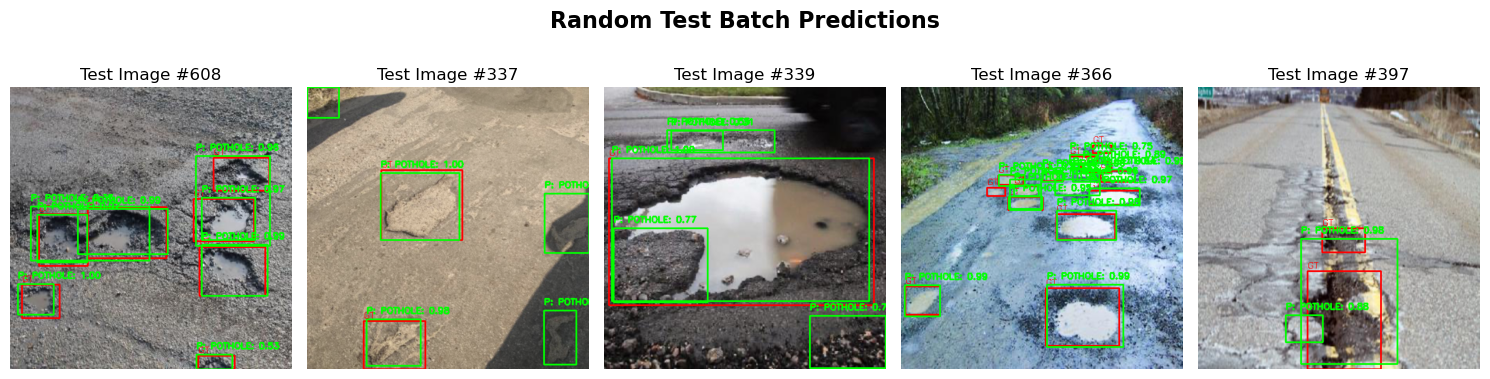

In [67]:
# Load the trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=len(PotholeSeverity)) 
state_dict = torch.load("faster_rcnn_pothole.pth", weights_only=True)
model.load_state_dict(state_dict)
model.to(device)  # Move the model to the GPU
model.eval()  # Set the model to evaluation mode

# Define the TestLoader
test_loader = DataLoader(test_set, batch_size=5, shuffle=True, collate_fn=collate_fn)

# Evaluate the model on the test set
threshold = 0.3
all_predictions = evaluate_model(model, test_loader, threshold=threshold)

# Visualize a random test batch
random_batch = random.choice(list(test_loader))  # Select a random batch
images, targets = random_batch

visualize_predictions(images, targets, all_predictions, threshold=threshold, show_severity=True)



## ViT

## Comparison

## Smearing Noise

## Conclusions